**Load Datasets**

In [54]:
import pandas as pd

In [57]:
# Load CSVs
products = pd.read_csv("product_details.csv")
inventory = pd.read_csv("inventory_data.csv")
anomalies = pd.read_csv("anomalies.csv")

# Quick look at data
print("-"*80)
print(products.head())
print("-"*80)
print(inventory.head())
print("-"*80)
print(anomalies.head())
print("-"*80)

--------------------------------------------------------------------------------
  Product_ID              Product_Name       Category               Brand  \
0       P001             Tata Salt 1kg        Grocery                Tata   
1       P002   Colgate Toothpaste 100g  Personal Care             Colgate   
2       P003  Fortune Sunflower Oil 1L        Grocery        Adani Wilmar   
3       P004              Lux Soap Bar  Personal Care  Hindustan Unilever   
4       P005  Britannia Marie Biscuits         Snacks           Britannia   

   Cost_Price  Selling_Price  Reorder_Level  Shelf_Life_Days  
0          20             25             30              730  
1          40             60             25              720  
2         120            150             40              365  
3          25             40             20              730  
4          15             25             30              180  
------------------------------------------------------------------------------

In [58]:
# Merge to include product names
data = pd.merge(inventory, products, on='Product_ID', how='left')
print(data.head())
print("-"*80)
# Check columns
print(data.columns)

         Date Warehouse_ID Product_ID            Product_Name_x  \
0  2025-01-01         W001       P001             Tata Salt 1kg   
1  2025-01-01         W001       P002   Colgate Toothpaste 100g   
2  2025-01-01         W001       P003  Fortune Sunflower Oil 1L   
3  2025-01-01         W001       P004              Lux Soap Bar   
4  2025-01-01         W001       P005  Britannia Marie Biscuits   

      Category_x             Brand_x  Stock_Level  Sales  Reorder_Level_x  \
0        Grocery                Tata          222     21               30   
1  Personal Care             Colgate          126     16               25   
2        Grocery        Adani Wilmar          230     23               40   
3  Personal Care  Hindustan Unilever          216     15               20   
4         Snacks           Britannia          140     -1               30   

             Product_Name_y     Category_y             Brand_y  Cost_Price  \
0             Tata Salt 1kg        Grocery              

In [59]:
# Merge and fix duplicates
data = pd.merge(inventory, products, on='Product_ID', how='left')

# Remove duplicate columns if any
data = data.loc[:, ~data.columns.duplicated()]

# Rename columns properly
data.rename(columns={'Product_Name_x': 'Product_Name'}, inplace=True)


In [60]:
# Flatten any multi-level columns (in case merge created them)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Remove duplicate columns
data = data.loc[:, ~data.columns.duplicated()]

# Try to detect a product name column
possible_names = [col for col in data.columns if 'product' in col.lower()]
print("Detected product name columns:", possible_names)

# Create a clean 'Product_Name' column
if len(possible_names) > 0:
    data['Product_Name'] = data[possible_names[0]].astype(str)
else:
    data['Product_Name'] = 'Unknown'

# Convert date
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Ensure numeric
data['Stock_Level'] = pd.to_numeric(data['Stock_Level'], errors='coerce')


Detected product name columns: ['Product_ID', 'Product_Name', 'Product_Name_y']


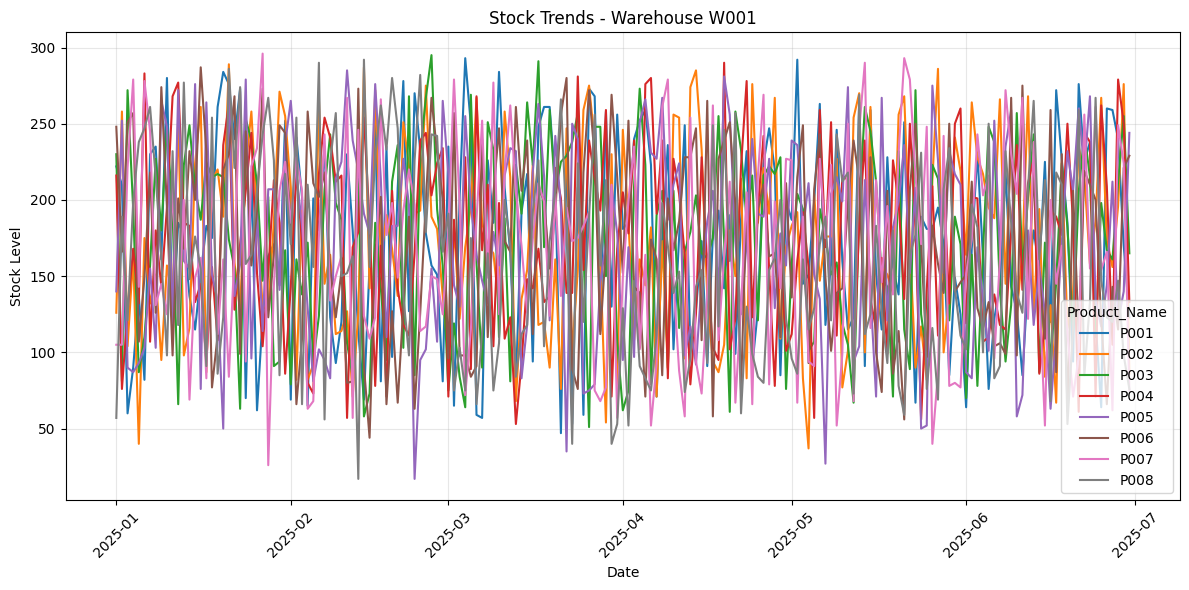

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

warehouse_id = data['Warehouse_ID'].unique()[0]     # replace this with any warehouse
warehouse_data = (
    data[data['Warehouse_ID'] == warehouse_id]
    .groupby(['Date', 'Product_Name'], as_index=False)['Stock_Level']
    .sum()
    .sort_values('Date')
)

plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Stock_Level', hue='Product_Name', data=warehouse_data)
plt.title(f"Stock Trends - Warehouse {warehouse_id}")
plt.xlabel("Date")
plt.ylabel("Stock Level")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [62]:
print(data['Product_Name'].unique())

['P001' 'P002' 'P003' 'P004' 'P005' 'P006' 'P007' 'P008']


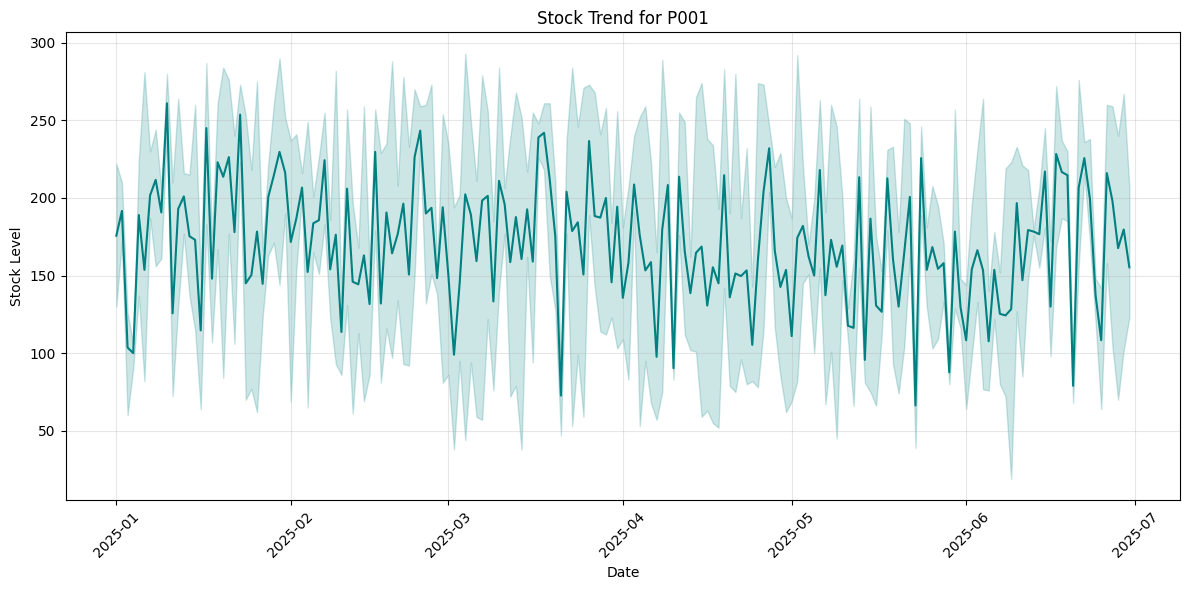

In [63]:
# Choose the product you want to visualize
product_name = "P001"  # replace this with any product from your dataset

product_data = data[data['Product_Name'] == product_name]
plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Stock_Level', data=product_data, color='teal')
plt.title(f"Stock Trend for {product_name}")
plt.xlabel("Date")
plt.ylabel("Stock Level")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


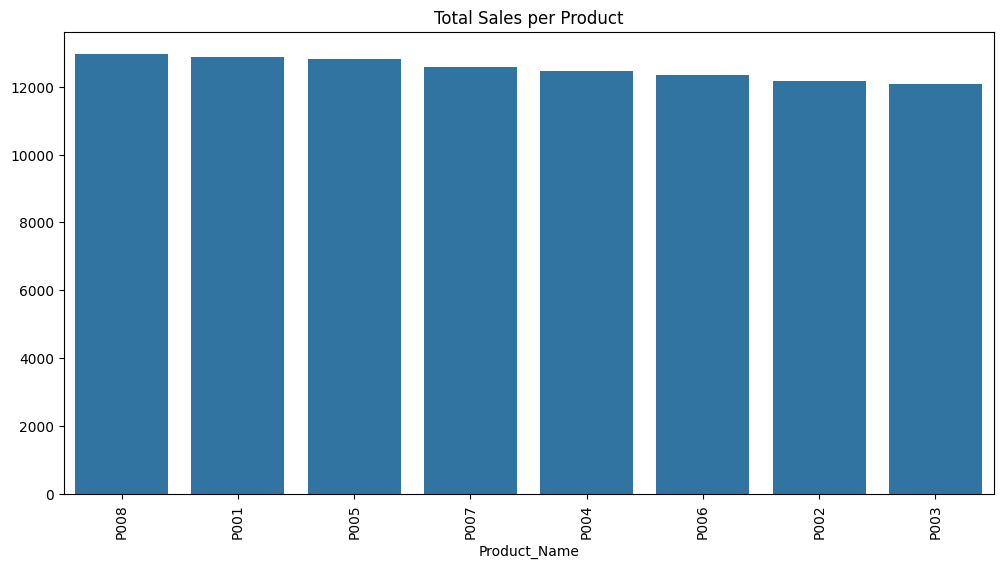

In [64]:
# Sales per product
sales_product = data.groupby('Product_Name')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=sales_product.index, y=sales_product.values)
plt.title("Total Sales per Product")
plt.xticks(rotation=90)
plt.show()



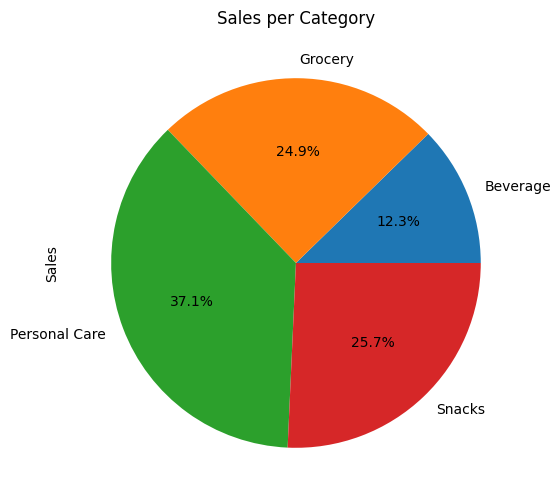

In [65]:
# Sales per category
sales_category = data.groupby('Category_x')['Sales'].sum()
sales_category.plot(kind='pie', autopct='%1.1f%%', figsize=(6,6), title='Sales per Category')
plt.show()

In [66]:
print(anomalies.head())
print(anomalies.columns)

         Date Warehouse_ID Product_ID               Product_Name  \
0  2025-01-02         W003       P003   Fortune Sunflower Oil 1L   
1  2025-01-05         W001       P002    Colgate Toothpaste 100g   
2  2025-01-09         W001       P007  Dabur Amla Hair Oil 200ml   
3  2025-01-15         W002       P005   Britannia Marie Biscuits   
4  2025-01-17         W002       P008    Maggi Noodles 2-min 70g   

          Brand      Anomaly_Type  Stock_Level  Sales Severity Resolved  
0  Adani Wilmar  High sales spike          137     59     High       No  
1       Colgate  High sales spike           40     58     High       No  
2         Dabur  High sales spike          145     55     High       No  
3     Britannia  High sales spike           93     57     High       No  
4  Nestle India  High sales spike          106     56     High       No  
Index(['Date', 'Warehouse_ID', 'Product_ID', 'Product_Name', 'Brand',
       'Anomaly_Type', 'Stock_Level', 'Sales', 'Severity', 'Resolved'],
     

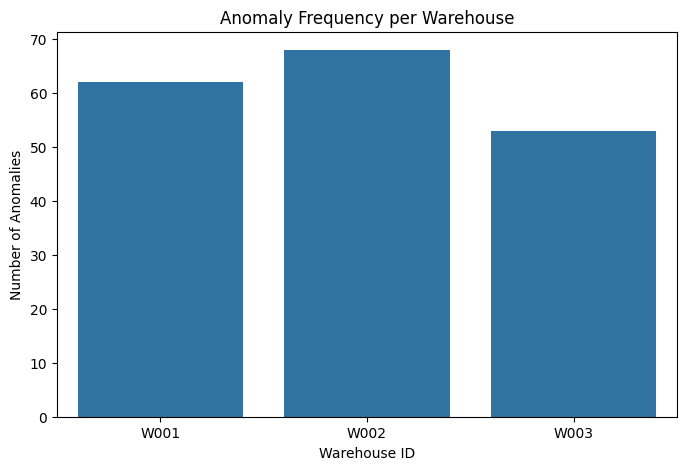

In [67]:
# Count number of anomalies per warehouse
anomaly_counts = anomalies.groupby('Warehouse_ID').size().reset_index(name='Anomaly_Count')

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='Warehouse_ID', y='Anomaly_Count', data=anomaly_counts,)
plt.title("Anomaly Frequency per Warehouse")
plt.xlabel("Warehouse ID")
plt.ylabel("Number of Anomalies")
plt.show()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/gsnmpgs6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/03oqforx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8904', 'data', 'file=/tmp/tmpdaary1ol/gsnmpgs6.json', 'init=/tmp/tmpdaary1ol/03oqforx.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modeljo94vtlf/prophet_model-20251021153946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


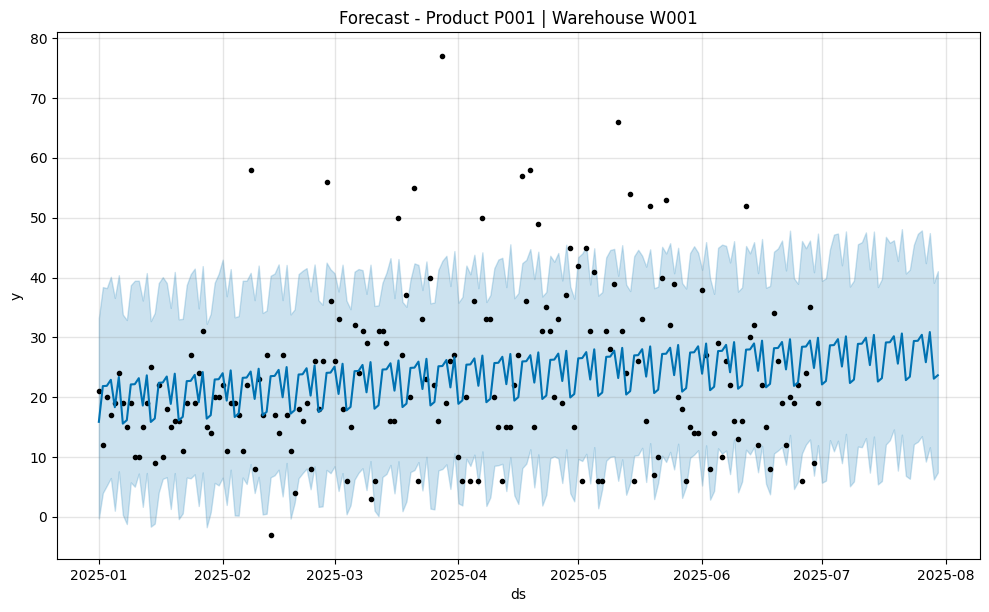

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/u34dl21f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/mkkfaej3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17362', 'data', 'file=/tmp/tmpdaary1ol/u34dl21f.json', 'init=/tmp/tmpdaary1ol/mkkfaej3.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelxxgmsvxj/prophet_model-20251021153947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


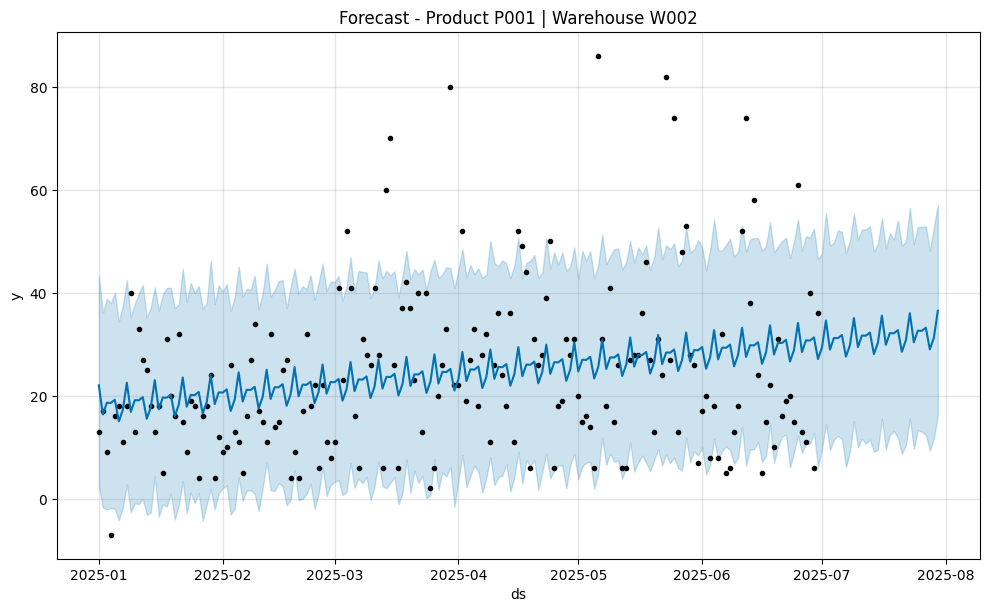

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/e0z7pt1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/3cdvie7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25461', 'data', 'file=/tmp/tmpdaary1ol/e0z7pt1j.json', 'init=/tmp/tmpdaary1ol/3cdvie7e.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelctdz7sgl/prophet_model-20251021153947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


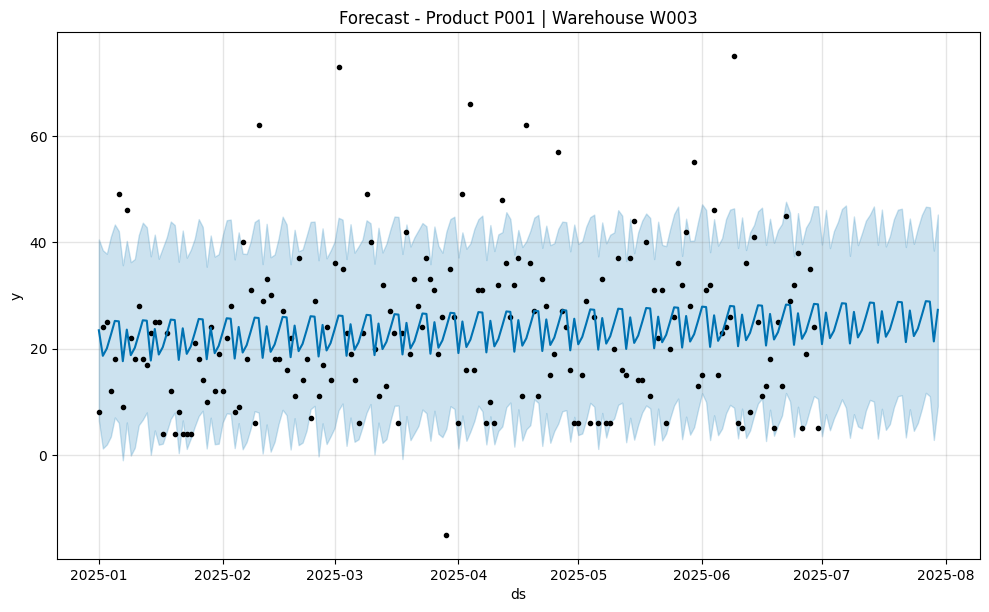

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/pc1ddaso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/um1qcs7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80454', 'data', 'file=/tmp/tmpdaary1ol/pc1ddaso.json', 'init=/tmp/tmpdaary1ol/um1qcs7x.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model4ay8_rkb/prophet_model-20251021153948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


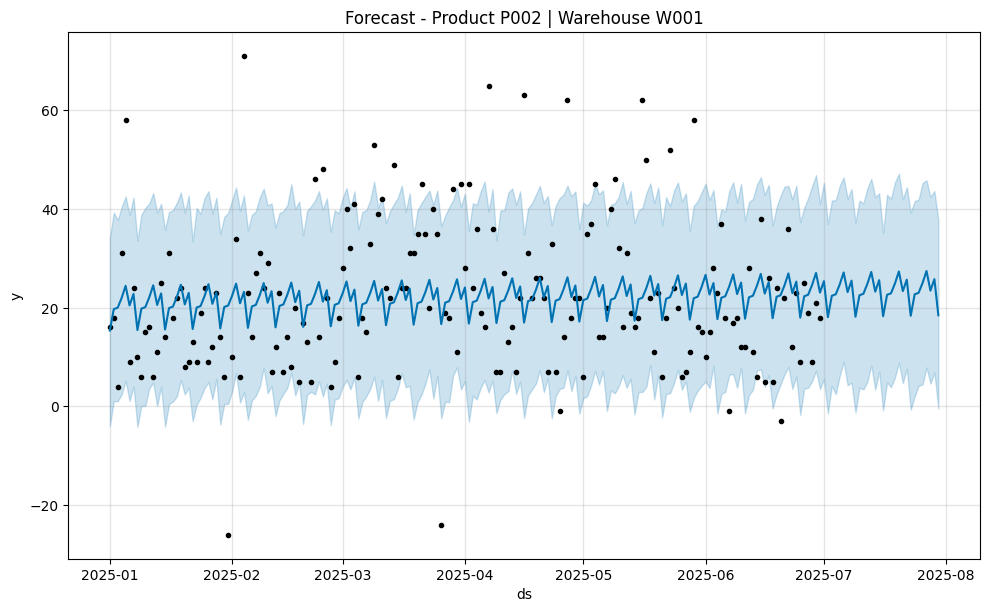

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/yzmhcvzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/lp64cdjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42727', 'data', 'file=/tmp/tmpdaary1ol/yzmhcvzc.json', 'init=/tmp/tmpdaary1ol/lp64cdjx.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model6eztlmpe/prophet_model-20251021153948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


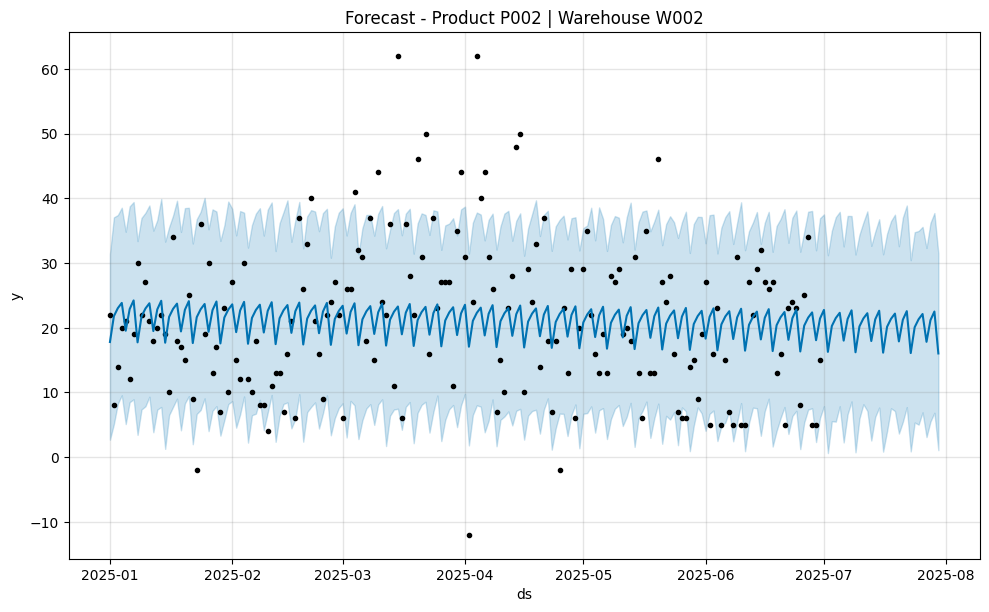

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/rpukv2xe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/aqcx1jj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65311', 'data', 'file=/tmp/tmpdaary1ol/rpukv2xe.json', 'init=/tmp/tmpdaary1ol/aqcx1jj6.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model2074tsyi/prophet_model-20251021153949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


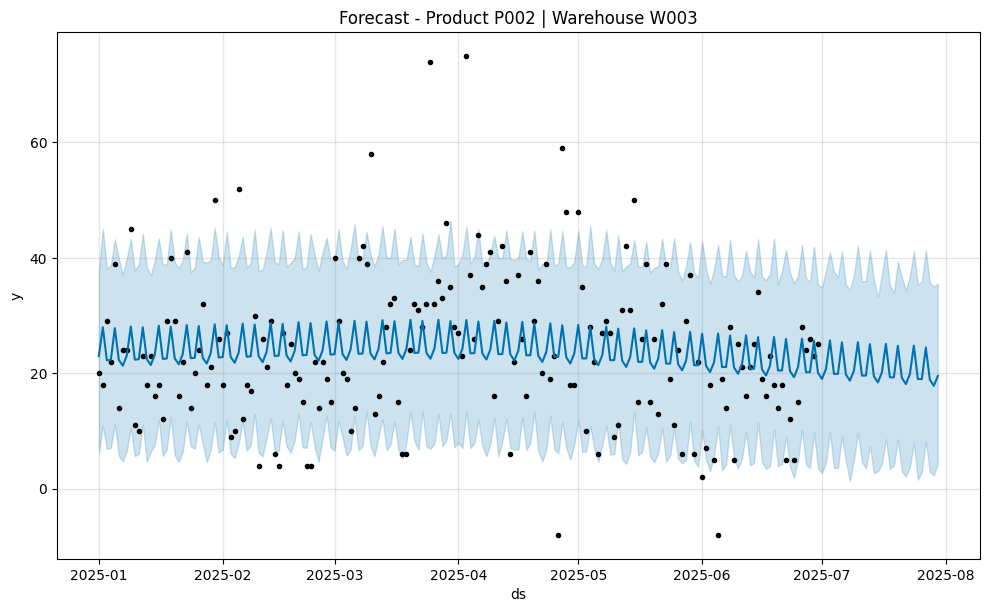

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/jzr1m4ky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/tp1eg0sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66913', 'data', 'file=/tmp/tmpdaary1ol/jzr1m4ky.json', 'init=/tmp/tmpdaary1ol/tp1eg0sh.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelw1_7d2yj/prophet_model-20251021153949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


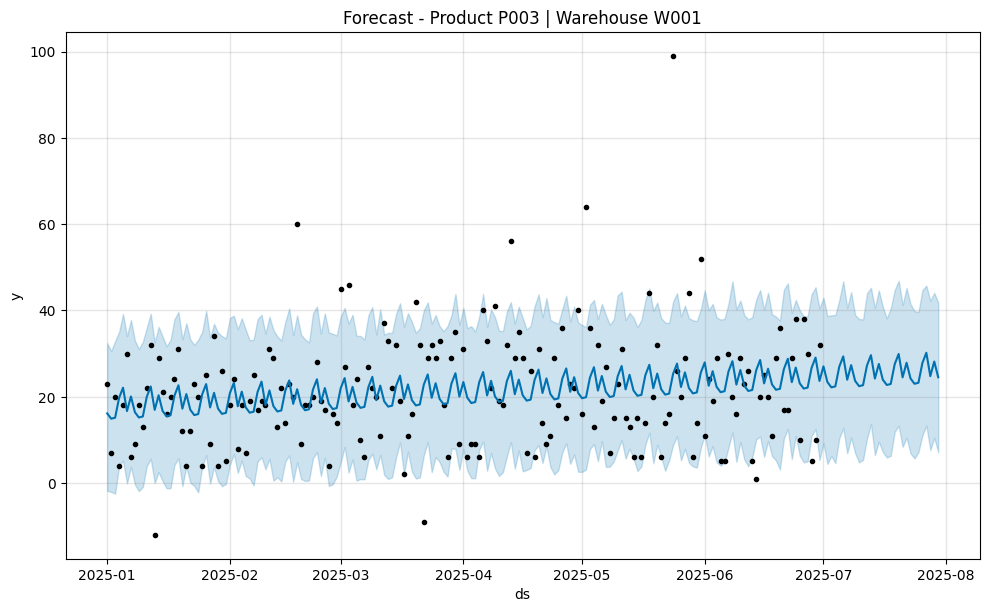

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/k7we5grr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/3d6vva71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59642', 'data', 'file=/tmp/tmpdaary1ol/k7we5grr.json', 'init=/tmp/tmpdaary1ol/3d6vva71.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelczhrxdoz/prophet_model-20251021153950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


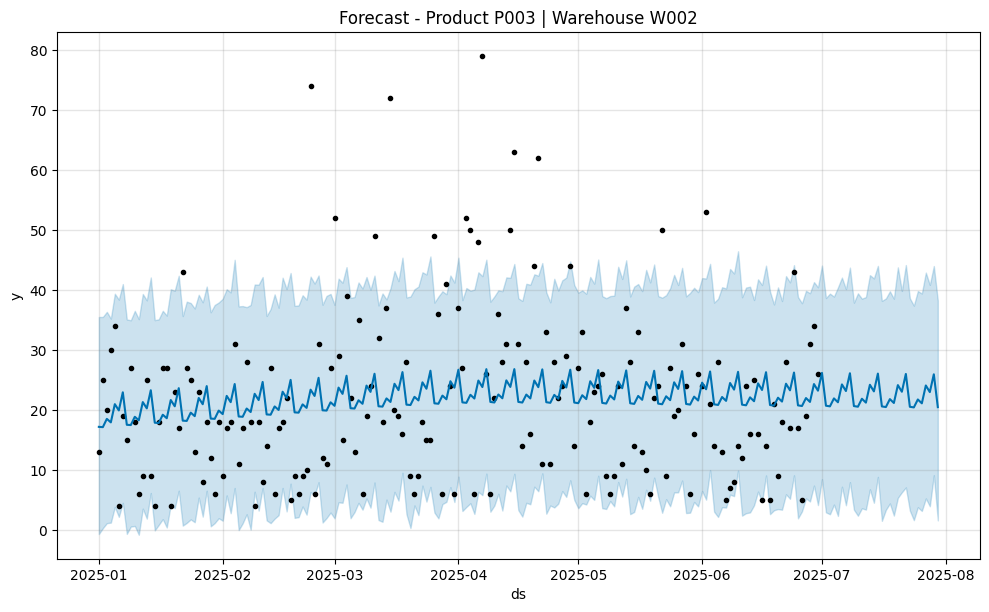

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/xyv01_7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/_htxsler.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60010', 'data', 'file=/tmp/tmpdaary1ol/xyv01_7x.json', 'init=/tmp/tmpdaary1ol/_htxsler.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelica3yeim/prophet_model-20251021153951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


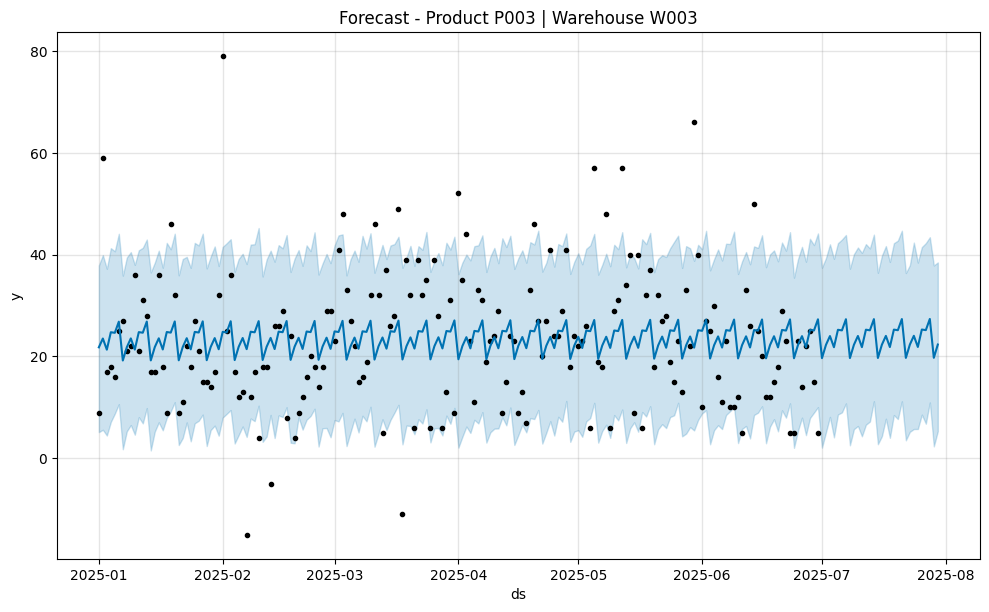

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/ra51v0e4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/tgd881et.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2360', 'data', 'file=/tmp/tmpdaary1ol/ra51v0e4.json', 'init=/tmp/tmpdaary1ol/tgd881et.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelkkzy8g8g/prophet_model-20251021153952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


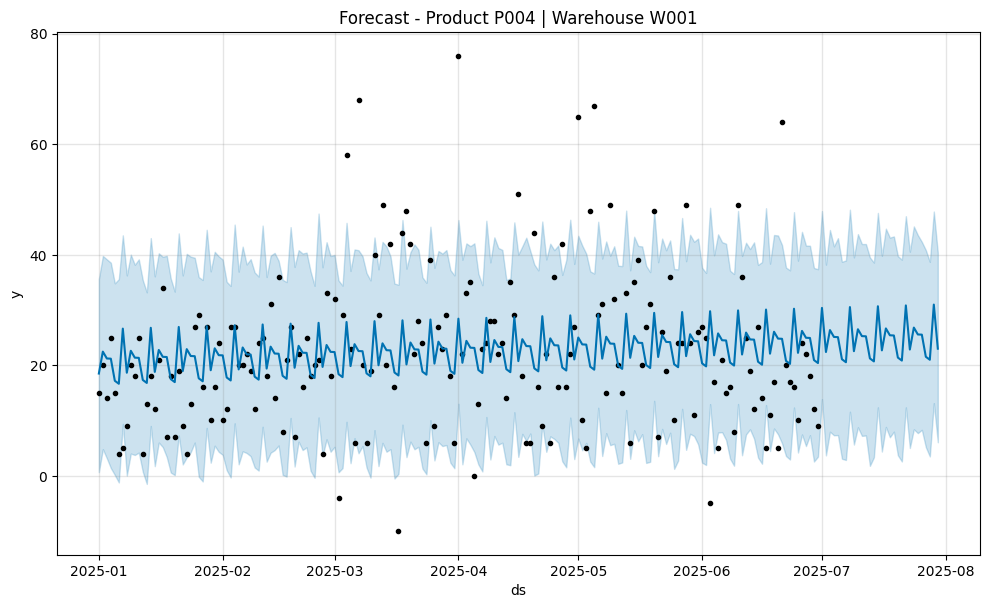

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/oi8y00ar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/xvg_uh0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27300', 'data', 'file=/tmp/tmpdaary1ol/oi8y00ar.json', 'init=/tmp/tmpdaary1ol/xvg_uh0a.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelrnrs4810/prophet_model-20251021153952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


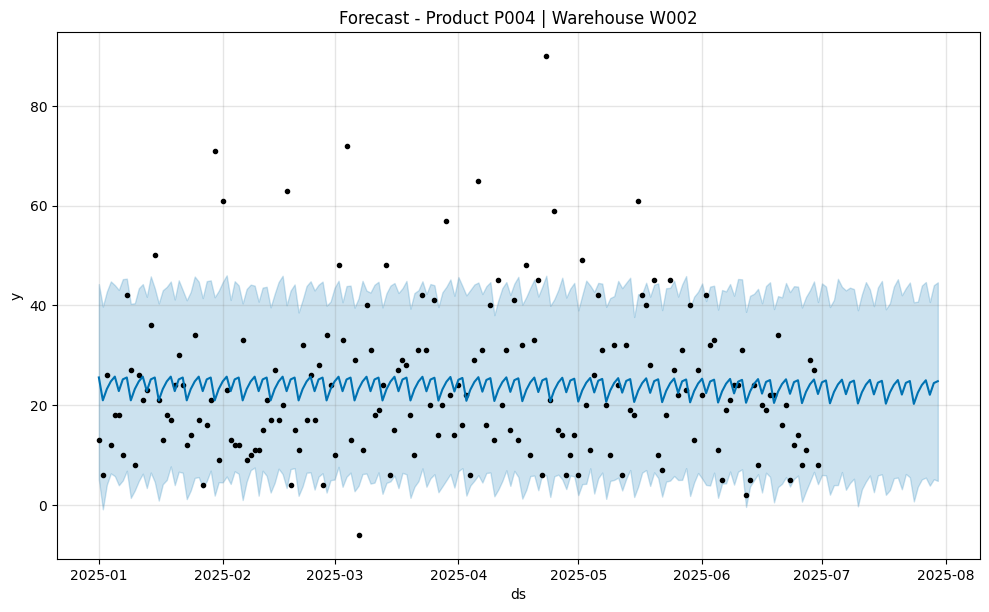

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/enws01hv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/o0_yjp_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2068', 'data', 'file=/tmp/tmpdaary1ol/enws01hv.json', 'init=/tmp/tmpdaary1ol/o0_yjp_f.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model97z_i5v7/prophet_model-20251021153953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


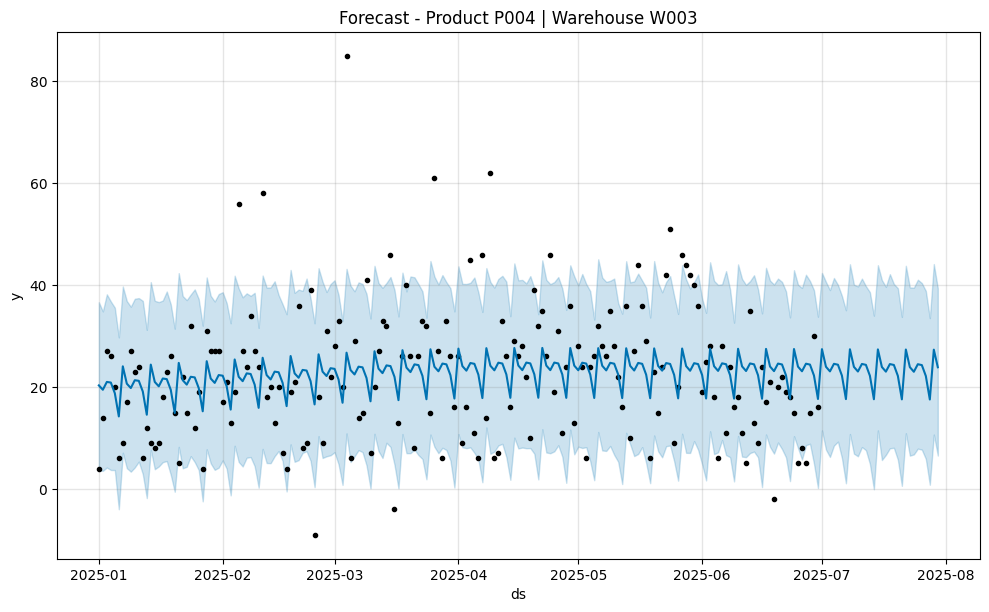

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/_y5vgdss.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/t9kpv9ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48616', 'data', 'file=/tmp/tmpdaary1ol/_y5vgdss.json', 'init=/tmp/tmpdaary1ol/t9kpv9ez.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelgilde5nt/prophet_model-20251021153953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


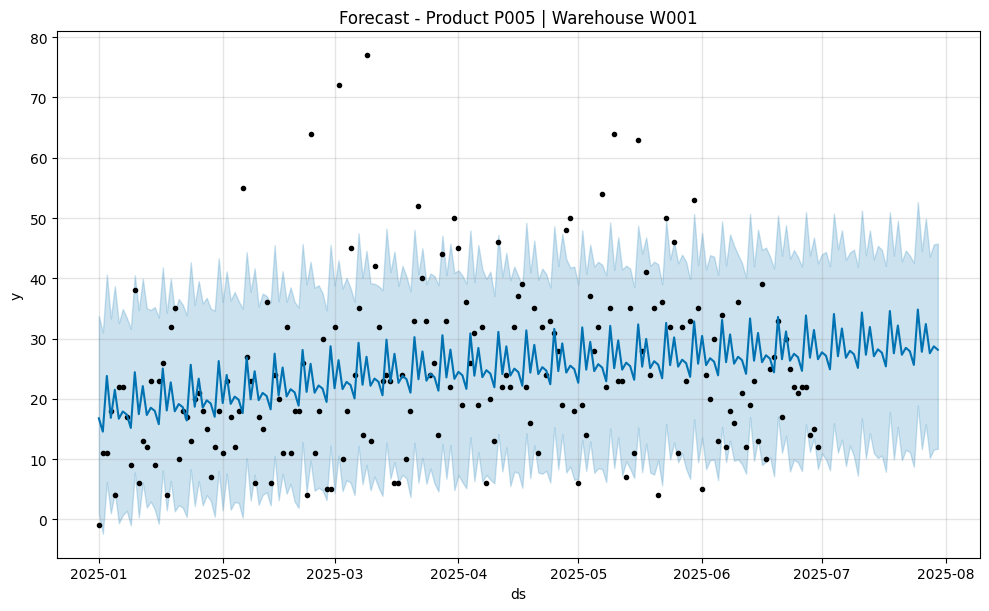

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/op6qmmc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/u17wbx2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67219', 'data', 'file=/tmp/tmpdaary1ol/op6qmmc8.json', 'init=/tmp/tmpdaary1ol/u17wbx2k.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model4xwmayqc/prophet_model-20251021153953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


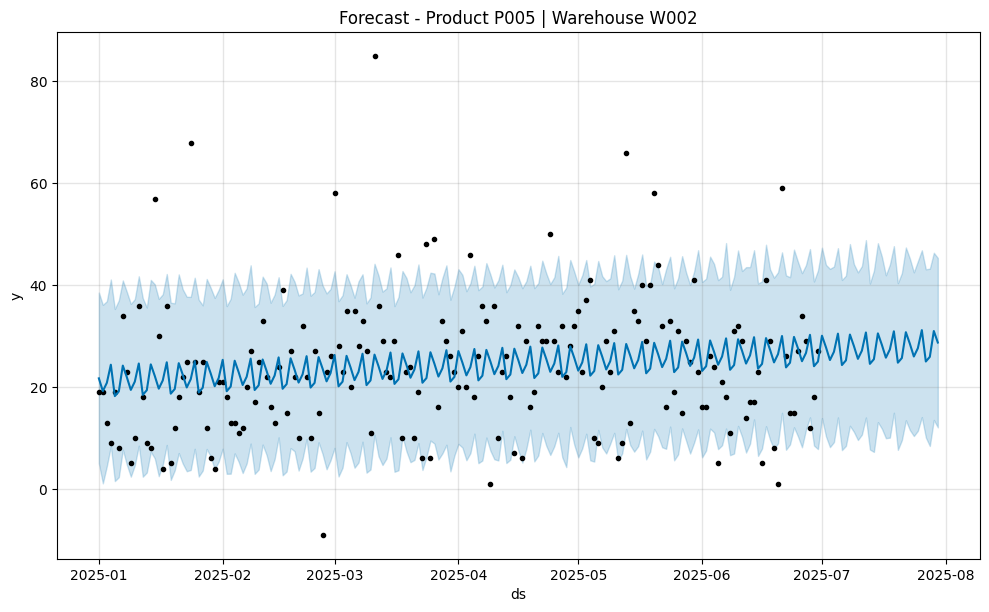

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/k5iv8r7v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/4e8viud4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87040', 'data', 'file=/tmp/tmpdaary1ol/k5iv8r7v.json', 'init=/tmp/tmpdaary1ol/4e8viud4.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modeli5fo9awj/prophet_model-20251021153954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


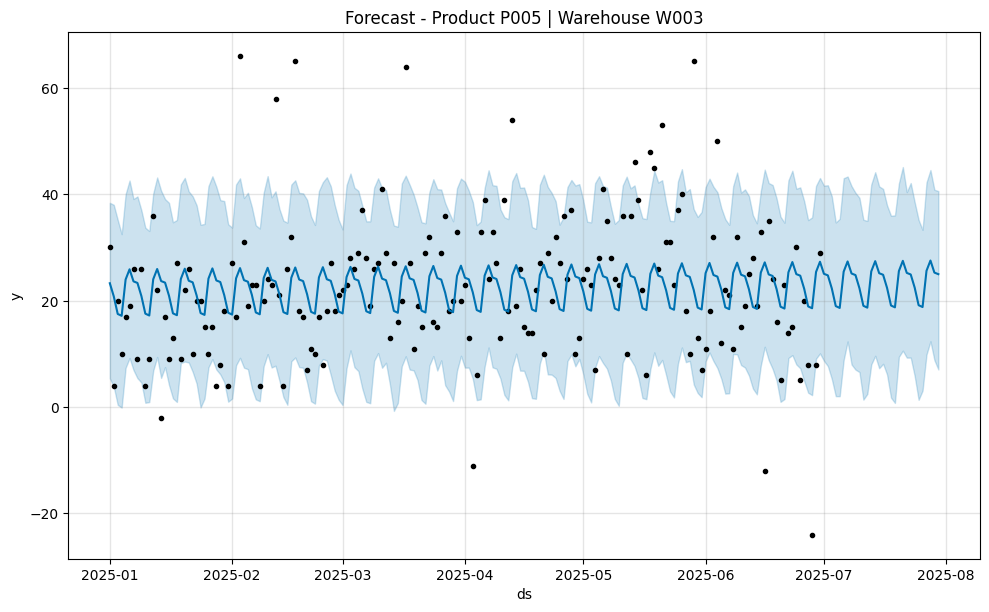

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/d1lp8z4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/uejb06t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63859', 'data', 'file=/tmp/tmpdaary1ol/d1lp8z4_.json', 'init=/tmp/tmpdaary1ol/uejb06t1.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modeldm3s65mi/prophet_model-20251021153954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


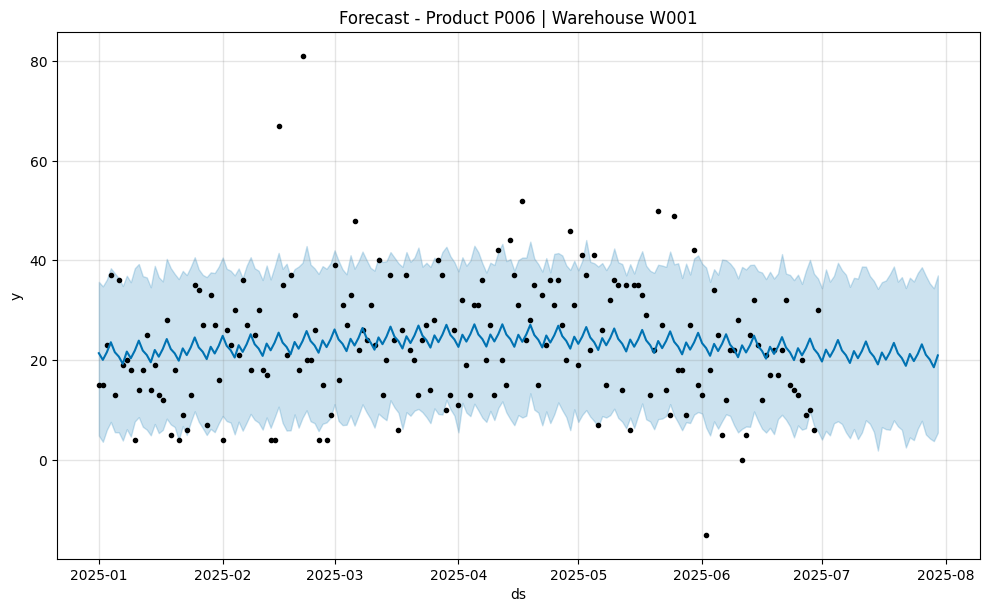

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/icw1tjmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/2k7rfy8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95524', 'data', 'file=/tmp/tmpdaary1ol/icw1tjmd.json', 'init=/tmp/tmpdaary1ol/2k7rfy8a.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelg7vhldgw/prophet_model-20251021153955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


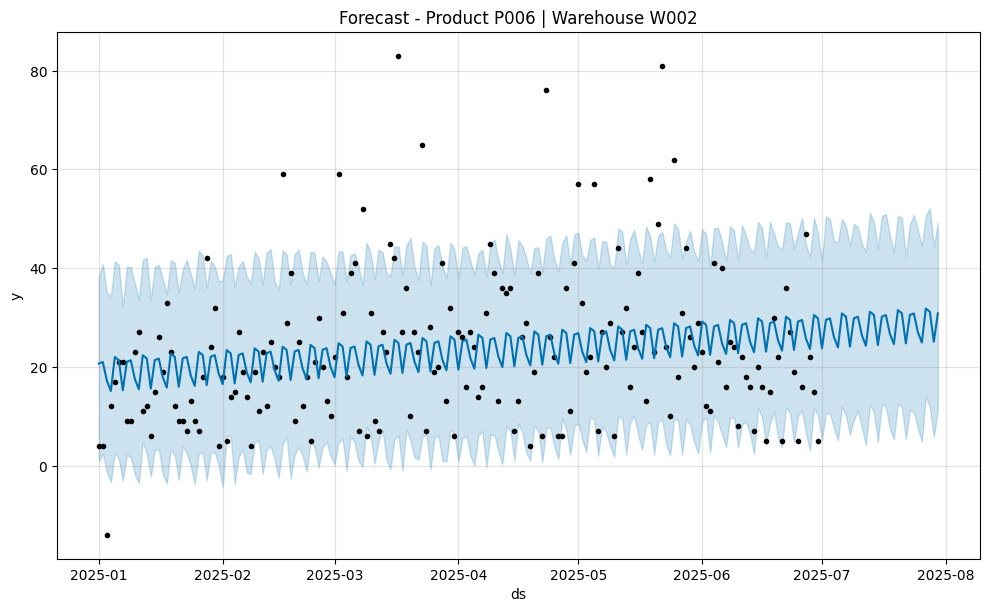

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/xjwm_kly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/vcpgv30a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93017', 'data', 'file=/tmp/tmpdaary1ol/xjwm_kly.json', 'init=/tmp/tmpdaary1ol/vcpgv30a.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model4ws875ki/prophet_model-20251021153955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


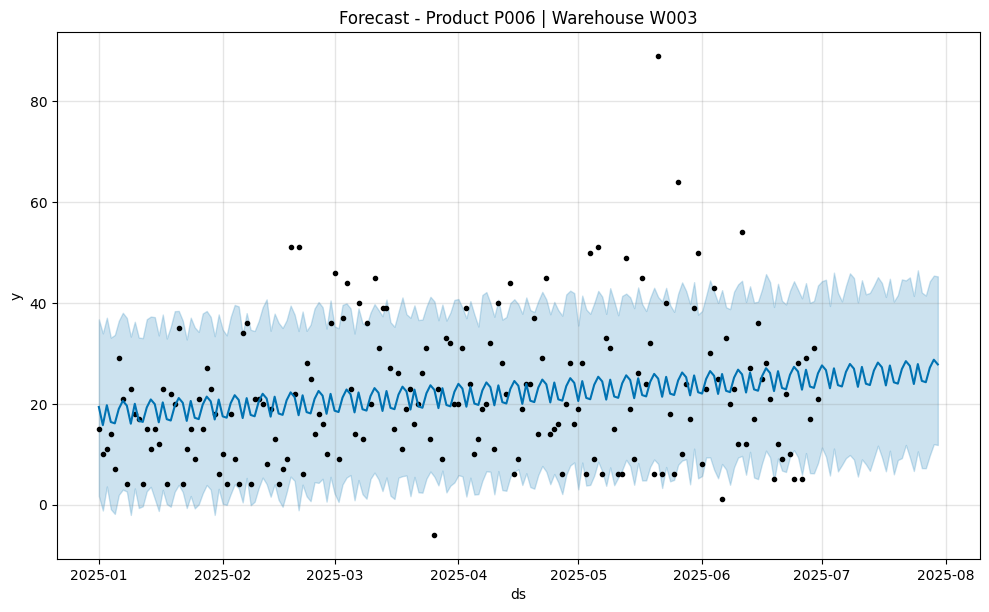

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/yqyztw3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/92t6jddv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8933', 'data', 'file=/tmp/tmpdaary1ol/yqyztw3d.json', 'init=/tmp/tmpdaary1ol/92t6jddv.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model451_7hqm/prophet_model-20251021153955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


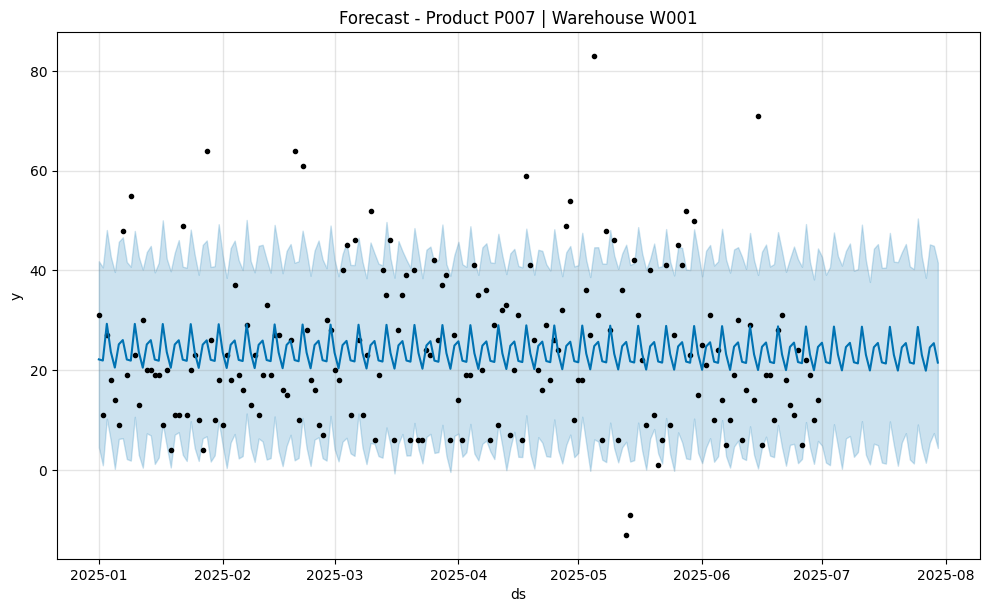

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/kxdd1_rj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/5nitj91q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32743', 'data', 'file=/tmp/tmpdaary1ol/kxdd1_rj.json', 'init=/tmp/tmpdaary1ol/5nitj91q.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelws9kovd7/prophet_model-20251021153956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


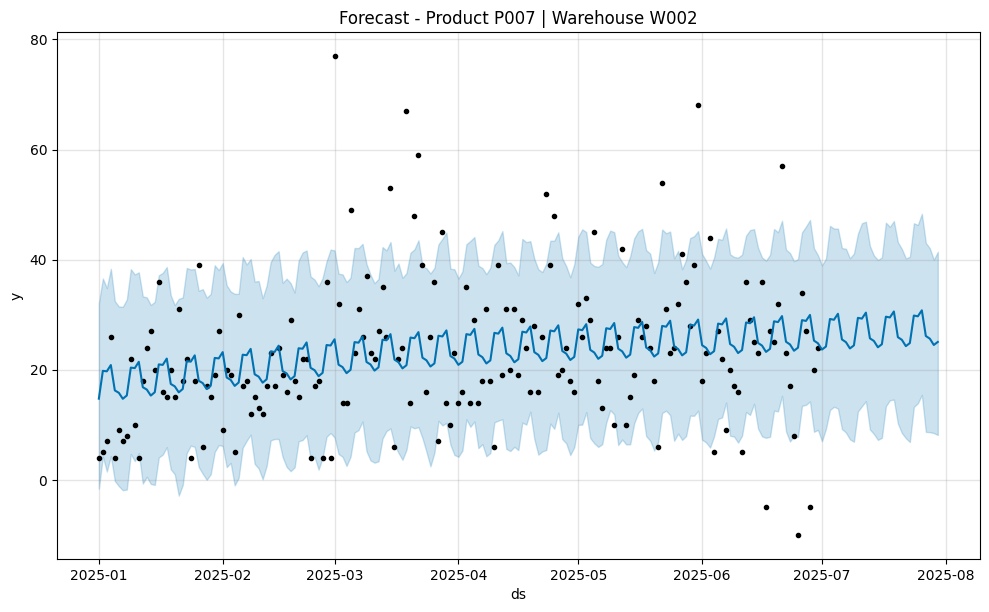

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/27f2fa0d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/hzuqfevd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90918', 'data', 'file=/tmp/tmpdaary1ol/27f2fa0d.json', 'init=/tmp/tmpdaary1ol/hzuqfevd.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelfvhix4w2/prophet_model-20251021153956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


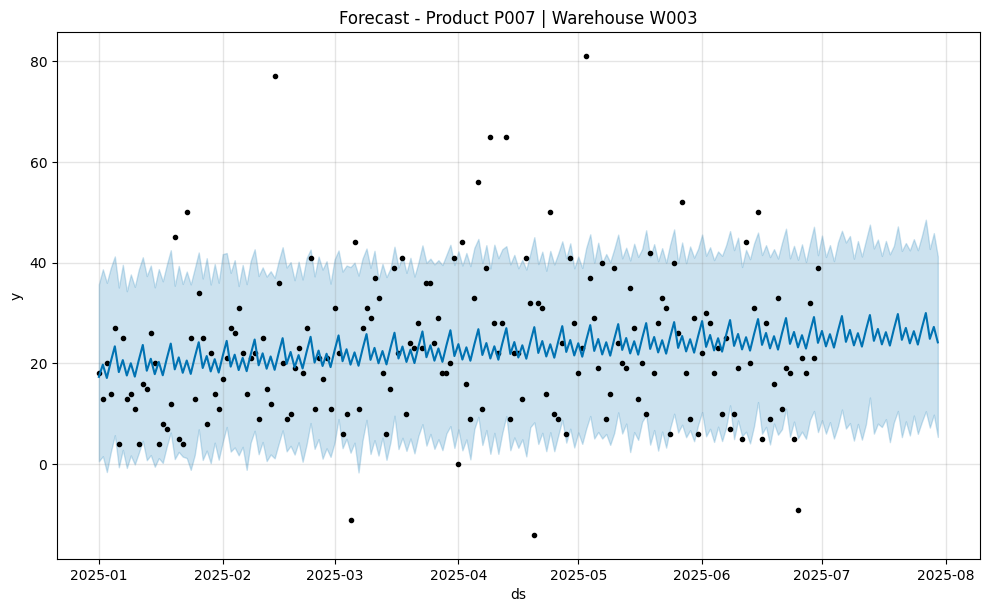

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/cxj8_cga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/0ickeuwl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52023', 'data', 'file=/tmp/tmpdaary1ol/cxj8_cga.json', 'init=/tmp/tmpdaary1ol/0ickeuwl.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelarf9qoca/prophet_model-20251021153956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


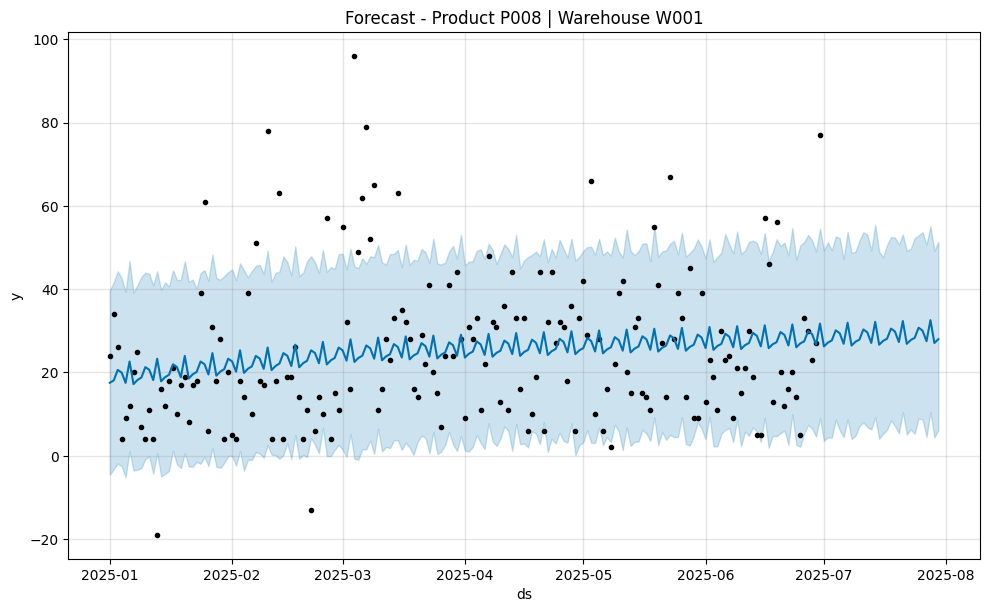

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/dznn2tki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/f_mvvl2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72226', 'data', 'file=/tmp/tmpdaary1ol/dznn2tki.json', 'init=/tmp/tmpdaary1ol/f_mvvl2y.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modelt2eh2g7l/prophet_model-20251021153957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


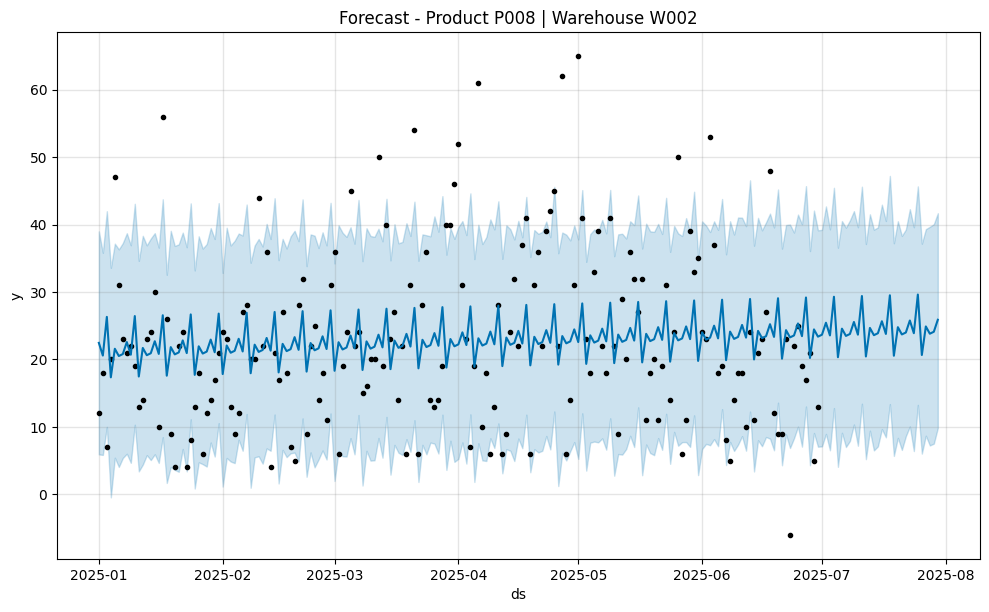

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/zluwz2sk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/9svq6ddj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97945', 'data', 'file=/tmp/tmpdaary1ol/zluwz2sk.json', 'init=/tmp/tmpdaary1ol/9svq6ddj.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_model4ibhiin3/prophet_model-20251021153957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


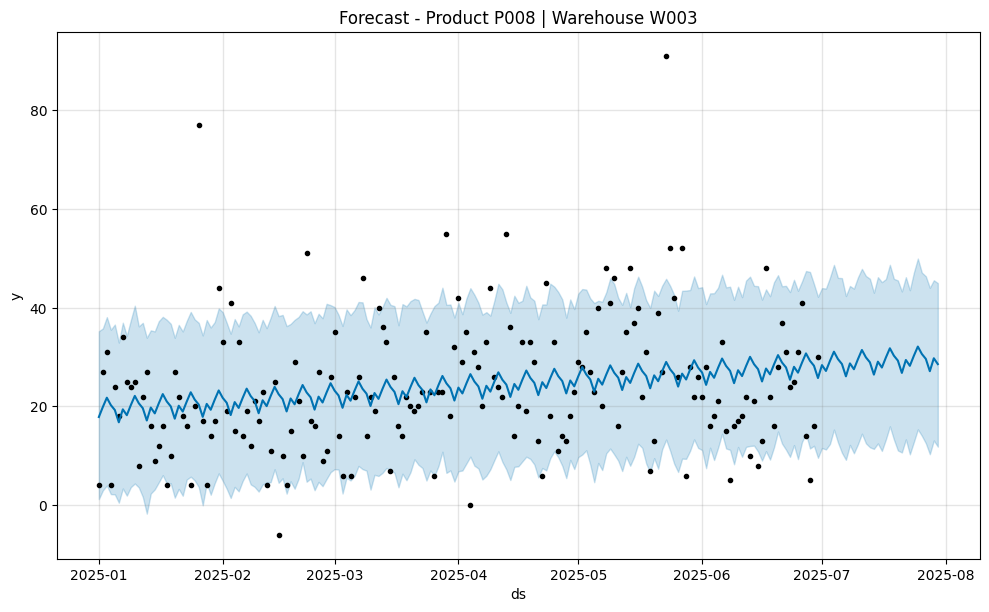

In [68]:
# Ensure data is loaded
data = pd.read_csv("inventory_data.csv")   # or your merged dataset
data['Date'] = pd.to_datetime(data['Date'])
data['Sales'] = pd.to_numeric(data['Sales'], errors='coerce')

# Create folder to save forecasts
os.makedirs("forecasts", exist_ok=True)

# Get unique products and warehouses
products = data['Product_ID'].unique()
warehouses = data['Warehouse_ID'].unique()

for pid in products:
    for wid in warehouses:
        df = data[(data['Product_ID']==pid) & (data['Warehouse_ID']==wid)][['Date','Sales']]
        df = df.rename(columns={'Date':'ds', 'Sales':'y'}).dropna()

        if len(df) < 10:   # Prophet needs enough data points
            continue

        # Train Prophet model
        model = Prophet(daily_seasonality=True)
        model.fit(df)

        # Forecast next 30 days
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)

        # Save forecast to CSV
        forecast_file = f"forecast_{pid}_{wid}.csv"
        forecast.to_csv(forecast_file, index=False)

        # Optional: plot forecast
        fig = model.plot(forecast)
        plt.title(f"Forecast - Product {pid} | Warehouse {wid}")
        plt.show()


In [69]:
print(anomalies.head())
print(anomalies.columns)

         Date Warehouse_ID Product_ID               Product_Name  \
0  2025-01-02         W003       P003   Fortune Sunflower Oil 1L   
1  2025-01-05         W001       P002    Colgate Toothpaste 100g   
2  2025-01-09         W001       P007  Dabur Amla Hair Oil 200ml   
3  2025-01-15         W002       P005   Britannia Marie Biscuits   
4  2025-01-17         W002       P008    Maggi Noodles 2-min 70g   

          Brand      Anomaly_Type  Stock_Level  Sales Severity Resolved  
0  Adani Wilmar  High sales spike          137     59     High       No  
1       Colgate  High sales spike           40     58     High       No  
2         Dabur  High sales spike          145     55     High       No  
3     Britannia  High sales spike           93     57     High       No  
4  Nestle India  High sales spike          106     56     High       No  
Index(['Date', 'Warehouse_ID', 'Product_ID', 'Product_Name', 'Brand',
       'Anomaly_Type', 'Stock_Level', 'Sales', 'Severity', 'Resolved'],
     

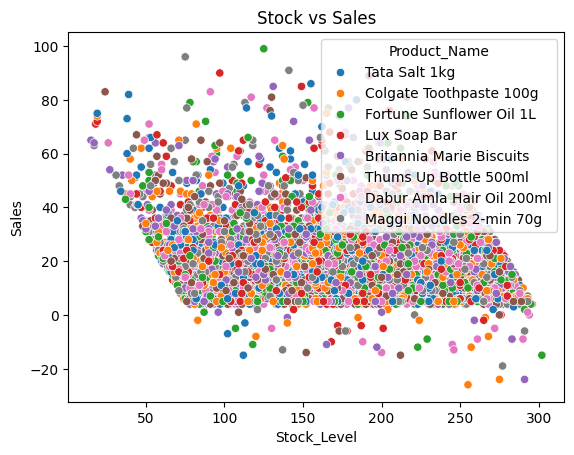

In [70]:
sns.scatterplot(x='Stock_Level', y='Sales', hue='Product_Name', data=data)
plt.title("Stock vs Sales")
plt.show()


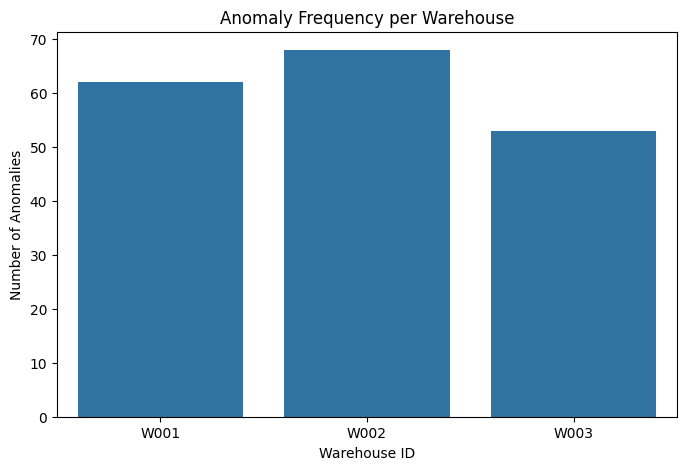

In [71]:
# Count number of anomalies per warehouse
anomaly_counts = anomalies.groupby('Warehouse_ID').size().reset_index(name='Anomaly_Count')

plt.figure(figsize=(8,5))
sns.barplot(x='Warehouse_ID', y='Anomaly_Count', data=anomaly_counts)
plt.title("Anomaly Frequency per Warehouse")
plt.xlabel("Warehouse ID")
plt.ylabel("Number of Anomalies")
plt.show()


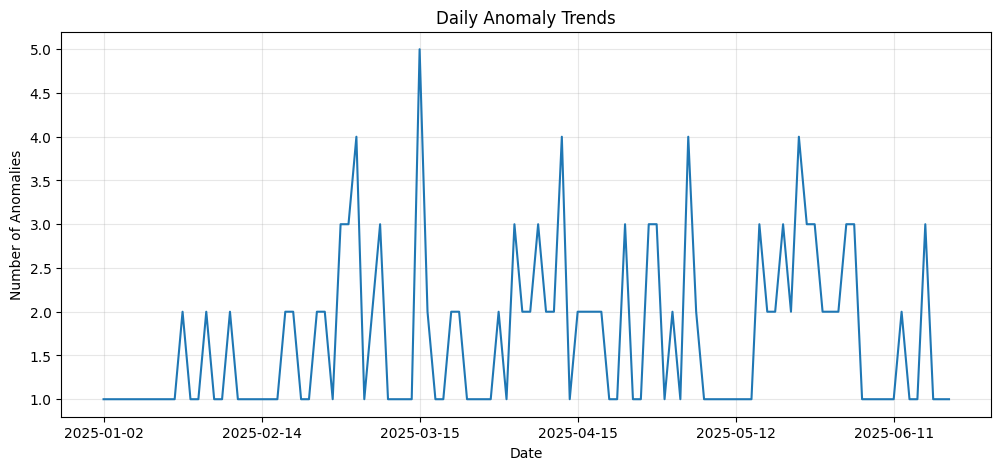

In [72]:
# Create a binary 'Anomaly' column
anomalies['Anomaly'] = 1

# Group by Date and sum
daily_anomalies = anomalies.groupby('Date')['Anomaly'].sum()

# Plot
daily_anomalies.plot(kind='line', figsize=(12,5), title="Daily Anomaly Trends")
plt.xlabel("Date")
plt.ylabel("Number of Anomalies")
plt.grid(True, alpha=0.3)
plt.show()


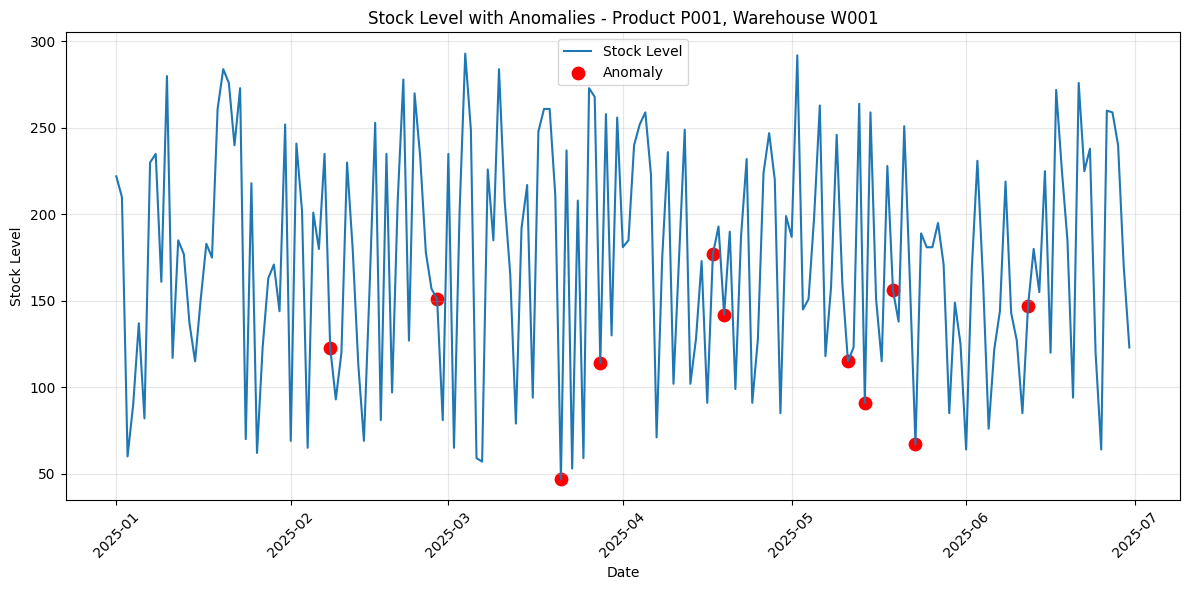

In [73]:
# Mark all rows in anomalies as 1
anomalies['Anomaly'] = 1
# Convert both to datetime
data['Date'] = pd.to_datetime(data['Date'])
anomalies['Date'] = pd.to_datetime(anomalies['Date'])
data_plot = data.merge(
    anomalies[['Date', 'Product_ID', 'Warehouse_ID', 'Anomaly_Type']],  # or create numeric 'Anomaly' column
    on=['Date','Product_ID','Warehouse_ID'],
    how='left'
)

# Mark anomaly presence as 1
data_plot['Anomaly'] = data_plot['Anomaly_Type'].notna().astype(int)
product_id = "P001"
warehouse_id = "W001"
df_plot = data_plot[(data_plot['Product_ID']==product_id) & (data_plot['Warehouse_ID']==warehouse_id)]

plt.figure(figsize=(12,6))
sns.lineplot(x='Date', y='Stock_Level', data=df_plot, label='Stock Level')

# Overlay anomalies
anomaly_points = df_plot[df_plot['Anomaly']==1]
plt.scatter(anomaly_points['Date'], anomaly_points['Stock_Level'], color='red', label='Anomaly', s=80)

plt.title(f"Stock Level with Anomalies - Product {product_id}, Warehouse {warehouse_id}")
plt.xlabel("Date")
plt.ylabel("Stock Level")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [74]:
product_id, warehouse_id = 1, 1
df = data[(data['Product_ID']==product_id) & (data['Warehouse_ID']==warehouse_id)][['Date', 'Sales']]
print(df)


Empty DataFrame
Columns: [Date, Sales]
Index: []


In [75]:
product_id = 1
df = data[data['Product_ID']==product_id].groupby('Date', as_index=False)['Sales'].sum()
df = df.rename(columns={'Date':'ds', 'Sales':'y'})

print(df)


Empty DataFrame
Columns: [ds, y]
Index: []


In [76]:
print(data['Product_ID'].unique())
print(data['Warehouse_ID'].unique())


['P001' 'P002' 'P003' 'P004' 'P005' 'P006' 'P007' 'P008']
['W001' 'W002' 'W003']


In [77]:
product_id = "P001"   # must match your CSV
warehouse_id = "W001" # must match your CSV


In [78]:
df = data[(data['Product_ID']==product_id) & (data['Warehouse_ID']==warehouse_id)][['Date', 'Sales']]
df = df.rename(columns={'Date':'ds', 'Sales':'y'})
print(df.head())


           ds   y
0  2025-01-01  21
24 2025-01-02  12
48 2025-01-03  20
72 2025-01-04  17
96 2025-01-05  19


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/x2ot6gc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdaary1ol/e6qbobvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95431', 'data', 'file=/tmp/tmpdaary1ol/x2ot6gc5.json', 'init=/tmp/tmpdaary1ol/e6qbobvi.json', 'output', 'file=/tmp/tmpdaary1ol/prophet_modeln3ip6q4d/prophet_model-20251021153958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:39:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:39:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


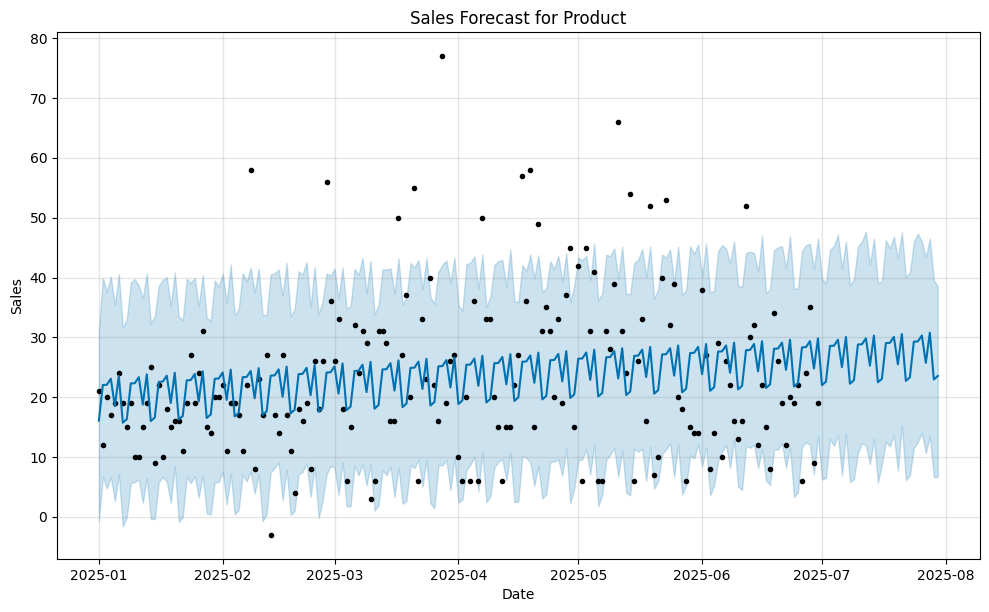

In [79]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Initialize and fit model
model = Prophet()
model.fit(df)

# Create future dataframe (next 30 days)
future = model.make_future_dataframe(periods=30)

# Predict
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Sales Forecast for Product")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


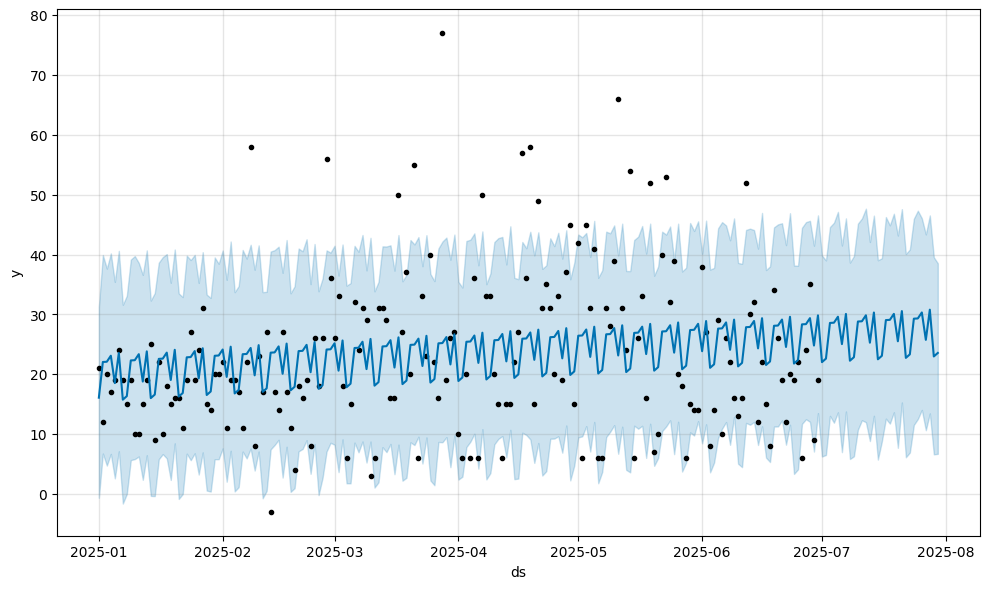

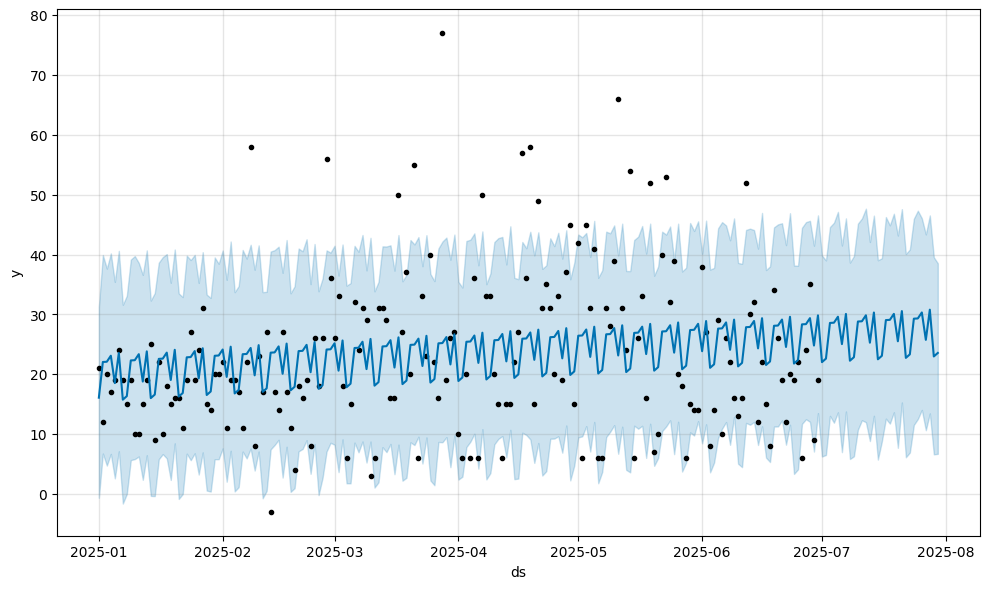

In [80]:
model.plot(forecast)  # Prophet example

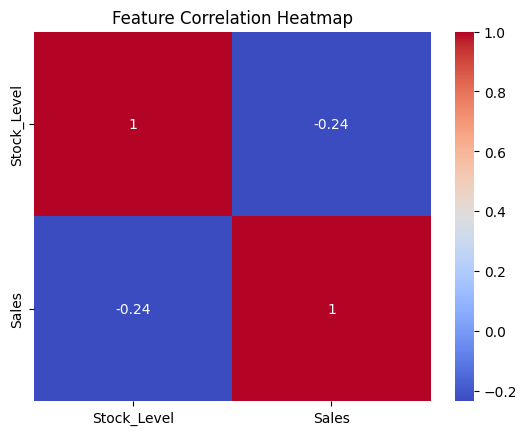

In [81]:
numeric_cols = ['Stock_Level', 'Sales']  # add only if they exist
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()
